### Import Library

In [537]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [538]:
X = pd.read_csv('dataset/fitur.csv').values
X

array([[0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [539]:
y = pd.read_csv('dataset/target.csv').values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

##### Inisialisasi bobot dan bias

In [541]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append(np.random.rand(4, hidden_neuron[i]).tolist())
        else:
            bobot.append(np.random.rand(hidden_neuron[i-1], hidden_neuron[i]).tolist())
        bias.append(np.random.rand(hidden_neuron[i]).tolist())
    bobot_output = np.random.rand(hidden_neuron[-1]).tolist()
    bias_output = np.random.rand()
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [542]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

def turunan_relu(x):
    if x > 0:
        return 1
    else:
        return 0 

##### Fungsi Training

In [543]:
def ann(epochs, hidden_layer, hidden_neuron, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(relu(sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = relu(sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunan_relu(prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i+1)][j] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [544]:
hidden_layer = 2
hidden_neuron = [2, 2]
lr = 0.005
epoch = 100

best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output = ann(epoch, hidden_layer, hidden_neuron, lr, X_train, y_train)

Epoch 1, MSE: 0.45090986172713815
Epoch 2, MSE: 0.04518740812472638
Epoch 3, MSE: 0.04492233831984239
Epoch 4, MSE: 0.044659604923745135
Epoch 5, MSE: 0.04439918616906951
Epoch 6, MSE: 0.044141060497887956
Epoch 7, MSE: 0.043885206559661466
Epoch 8, MSE: 0.043631603209205665
Epoch 9, MSE: 0.04338022950468491
Epoch 10, MSE: 0.043131064705617506
Epoch 11, MSE: 0.04288408827090877
Epoch 12, MSE: 0.04263927985689607
Epoch 13, MSE: 0.042396619315419624
Epoch 14, MSE: 0.042156086691907374
Epoch 15, MSE: 0.04191766222348265
Epoch 16, MSE: 0.04168132633708741
Epoch 17, MSE: 0.04144705964762637
Epoch 18, MSE: 0.041214842956127755
Epoch 19, MSE: 0.04098465724792271
Epoch 20, MSE: 0.04075648369084455
Epoch 21, MSE: 0.0405303036334421
Epoch 22, MSE: 0.04030609860321383
Epoch 23, MSE: 0.040083850304858386
Epoch 24, MSE: 0.039863540618541506
Epoch 25, MSE: 0.03964515159818213
Epoch 26, MSE: 0.039428665469752884
Epoch 27, MSE: 0.039214064629599296
Epoch 28, MSE: 0.039001331642775895
Epoch 29, MSE: 0.

In [545]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [2, 3]
    neuron_values = [2, 3]
    lr_values = [0.005, 0.01]
    epoch_values = [50, 100]

    hidden_layer_list = []
    hidden_neuron_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []

    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for lr in lr_values:
                for epoch in epoch_values:
                    print(f"HIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, LR={lr}, EPOCH={epoch}")
                    mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, list(hidden_neuron_combination), lr, X_train, y_train)
                    hidden_layer_list.append(hidden_layer)
                    hidden_neuron_list.append(tuple(hidden_neuron_combination))
                    lr_list.append(lr)
                    epoch_list.append(epoch)
                    mse_list.append(mse)
                    bobot_list.append(bobot)
                    bias_list.append(bias)
                    bobot_output_list.append(bobot_output)
                    bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [546]:
tuning = tuning_hyperparameters(X_train, y_train)

HIDDEN LAYER=2, HIDDEN NEURON=(2, 2), LR=0.005, EPOCH=50
Epoch 1, MSE: 8.55299138289106
Epoch 2, MSE: 0.07604161485276825
Epoch 3, MSE: 0.07549887112293985
Epoch 4, MSE: 0.07496108311536333
Epoch 5, MSE: 0.07442820368744259
Epoch 6, MSE: 0.07390018615537226
Epoch 7, MSE: 0.07337698428962501
Epoch 8, MSE: 0.07285855231047132
Epoch 9, MSE: 0.07234484488355311
Epoch 10, MSE: 0.07183581711549454
Epoch 11, MSE: 0.07133142454956341
Epoch 12, MSE: 0.07083162316136674
Epoch 13, MSE: 0.07033636935459792
Epoch 14, MSE: 0.06984561995681862
Epoch 15, MSE: 0.06935933221528896
Epoch 16, MSE: 0.06887746379283105
Epoch 17, MSE: 0.0683999727637446
Epoch 18, MSE: 0.06792681760975061
Epoch 19, MSE: 0.06745795721598466
Epoch 20, MSE: 0.06699335086702582
Epoch 21, MSE: 0.06653295824296504
Epoch 22, MSE: 0.06607673941551405
Epoch 23, MSE: 0.06562465484415039
Epoch 24, MSE: 0.06517666537230297
Epoch 25, MSE: 0.0647327322235753
Epoch 26, MSE: 0.06429281699800263
Epoch 27, MSE: 0.06385688166835232
Epoch 28, MS

##### Visualisasi hasil tuning

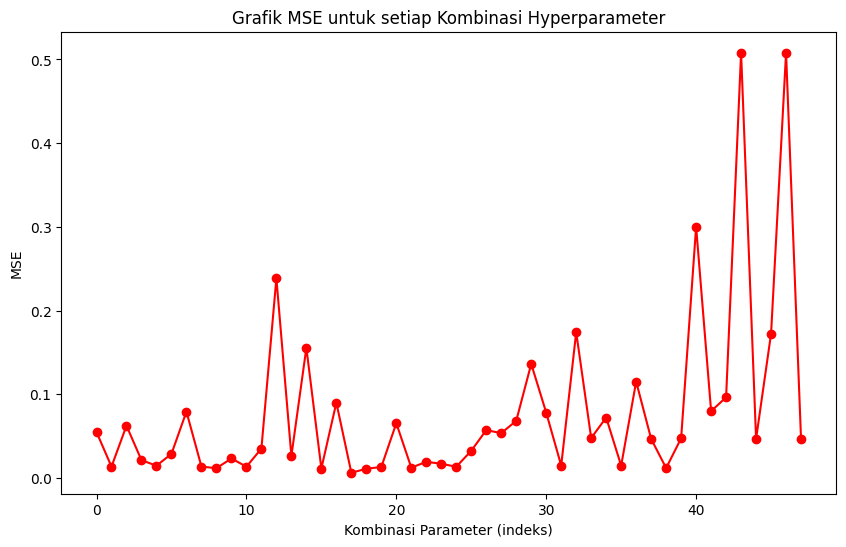

In [547]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [548]:
tuning

,hidden_layer,hidden_neuron,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,2,"(2, 2)",0.005,50,0.054847,"[[[0.3152182688870261, 0.8117107112106915], [0...","[[0.35710367750829997, 0.9696541204659708], [0...","[0.49786945708377983, 0.5214856420947729]",0.914880
1,2,"(2, 2)",0.005,100,0.013569,"[[[0.21330045671052233, 0.021664373736433817],...","[[0.7882401961655319, 0.5000538315298491], [0....","[0.27338180700077536, 0.5576675944504295]",0.760014
2,2,"(2, 2)",0.010,50,0.062440,"[[[0.7842309851182188, 0.26989706916255995], [...","[[0.17364452751324955, 0.47644563697510756], [...","[0.512717239665538, 0.46147859676445824]",0.480249
3,2,"(2, 2)",0.010,100,0.021264,"[[[0.4543445219440637, 0.5715140875778647], [0...","[[0.414400906107249, 0.6398311366090651], [0.5...","[0.05335498262715905, 0.08099886408244317]",0.603592
4,2,"(2, 3)",0.005,50,0.014678,"[[[0.9186117970312836, 0.9002214290931159], [0...","[[0.36392751178702654, 0.4040925493407561], [0...","[0.5557935505757332, 0.20415280783742895, 0.35...",0.769297
5,2,"(2, 3)",0.005,100,0.028818,"[[[0.9117801431369547, 0.5282157120051877], [0...","[[0.9161892962110657, 0.40741012394867715], [0...","[0.38140514935734404, 0.5579038310182861, 0.28...",0.839922
6,2,"(2, 3)",0.010,50,0.079260,"[[[0.5586258340839021, 0.6462108830556885], [0...","[[0.5510628668584138, 0.2373535910038298], [0....","[0.8755827159979228, 0.5922814213097257, 0.747...",0.446254
7,2,"(2, 3)",0.010,100,0.013661,"[[[0.9055567495154052, 0.1433003341246849], [0...","[[0.15455365610657723, 0.6221199091320406], [0...","[0.37952051545166676, 0.2586424415546961, 0.81...",0.760784
8,2,"(3, 2)",0.005,50,0.011655,"[[[0.44231964745008623, 0.5813748393227118, 0....","[[0.5699083056617497, 0.8448683849859479, 0.86...","[0.7344298206056256, 0.39696683335344346]",0.738304
9,2,"(3, 2)",0.005,100,0.023320,"[[[0.008080109970704186, 0.253046968436344, 0....","[[0.22521262125873287, 0.02581419969113785, 0....","[0.3140439039944559, 0.31307475505847787]",0.817865


In [549]:
best_index = tuning['mse'].idxmin()
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best MSE: 0.006287581609535858
Best Bobot: [[[np.float64(0.03444514541389454), np.float64(0.5644392833916835)], [np.float64(0.14658129776299422), np.float64(0.6327416224292987)], [np.float64(0.8371035111793321), np.float64(0.565924726397768)], [np.float64(0.04590370447568515), np.float64(0.5613526634912602)]], [[np.float64(0.26212266510364857), np.float64(0.39766351265622435)], [np.float64(0.3957427705913402), np.float64(0.8088035059285701)]], [[np.float64(0.021086433696871194), np.float64(1.089442370850458)], [np.float64(-0.19640617891391654), np.float64(2.2692177581270423)]]]
Best Bias: [[0.6869376329783354, np.float64(0.319967805922015)], [0.1754647678416169, np.float64(0.9965822344178658)], [0.3686485427563635, np.float64(1.3857616555879833)]]
Best Bobot Output: [np.float64(0.19726932418054138), np.float64(0.04558930703738369)]
Best Bias Output: 0.32282600461322125


### Prediksi X_test

##### Data testing

In [550]:
X_test

array([[0.72924046, 0.78047824, 0.77438659, 0.37263913],
       [0.66017316, 0.5876127 , 0.6888091 , 0.28629199],
       [0.50314837, 0.29086633, 0.48473968, 0.06663297],
       ...,
       [0.69047619, 0.79655037, 0.82405745, 0.37314462],
       [0.61275089, 0.36926695, 0.6181927 , 0.10096043],
       [0.5922865 , 0.69933359, 0.66367445, 0.33803594]])

##### Fungsi prediksi X_test

In [551]:
def predict(X_test, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_test)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_test[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Pemanggilan fungsi prediksi

In [552]:
prediksi = predict(X_test, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

##### Visualisasi hasil prediksi dan aktual

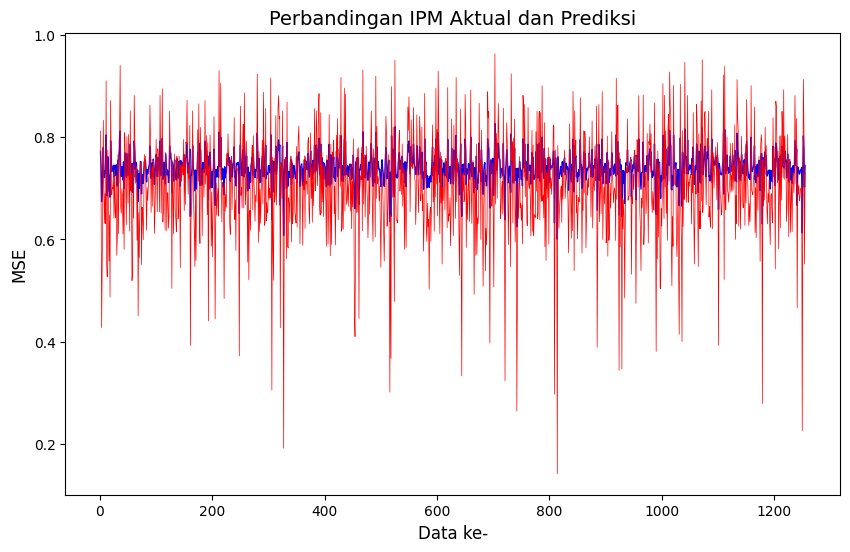

In [559]:
datake = list(range(1, len(y_test)+1))
plt.figure(figsize=(10, 6))
plt.plot(datake, prediksi, label="ipm prediksi", color='blue', linewidth=1)
plt.plot(datake, y_test, label="ipm aktual", color='red', linewidth=0.5)
plt.title('Perbandingan IPM Aktual dan Prediksi', fontsize=14)
plt.xlabel('Data ke-', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.show()

In [554]:
for i in range(len(y_test)):
    print(f"Aktual: {y_test[i]} - Prediksi: {prediksi[i]}")

Aktual: [0.8115351] - Prediksi: 0.7721254458831714
Aktual: [0.70841829] - Prediksi: 0.7397208618409761
Aktual: [0.42805127] - Prediksi: 0.6740411799615251
Aktual: [0.54631518] - Prediksi: 0.6922169060797114
Aktual: [0.67040489] - Prediksi: 0.7341467257124947
Aktual: [0.83236237] - Prediksi: 0.7797855585690016
Aktual: [0.69967958] - Prediksi: 0.7343335112665
Aktual: [0.63180891] - Prediksi: 0.7209093250256987
Aktual: [0.68948442] - Prediksi: 0.73380194083696
Aktual: [0.6307894] - Prediksi: 0.7290296721743773
Aktual: [0.90940868] - Prediksi: 0.8040557762570638
Aktual: [0.55257792] - Prediksi: 0.7051987222746521
Aktual: [0.52665307] - Prediksi: 0.6848989184798975
Aktual: [0.77468686] - Prediksi: 0.7614704317651442
Aktual: [0.68933877] - Prediksi: 0.7369168718606172
Aktual: [0.5576755] - Prediksi: 0.6942465408758959
Aktual: [0.64797553] - Prediksi: 0.7250677605818441
Aktual: [0.48762016] - Prediksi: 0.6825159900689048
Aktual: [0.87110399] - Prediksi: 0.7925590019766928
Aktual: [0.76696767]

### Prediksi Data Baru

##### Fungsi prediksi data baru

In [555]:
def predict(X_new, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_new)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_new[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Contoh prediksi

In [556]:
# angka_harapan_hidup, rerata_lama_sekolah, harapan_lama_sekolah, pengeluaran_per_kapita
X_new = [[65.655, 9.76, 14.28, 7686]]

minmax_scaler = joblib.load('fitur_mmscaler_model.pkl')
X_new_scaled = minmax_scaler.transform(X_new)

hasil_prediksi = predict(X_new_scaled, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)
hasil_prediksi

[np.float64(0.7472347599702645)]

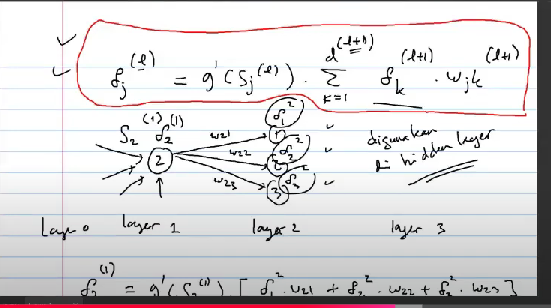

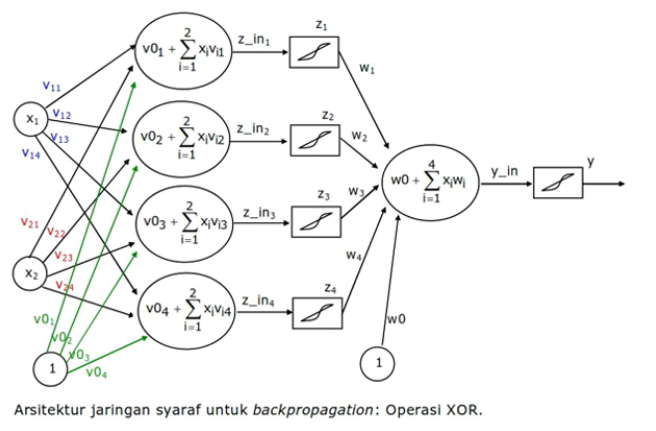